# Assignment 2

In this assignment you will create a coordinate-based multilayer perceptron in numpy from scratch. For each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

You will then compare the following input feature mappings $\gamma (\mathbf{v})$.

- No mapping: $\gamma(\mathbf{v})= \mathbf{v}$. 

- Basic mapping: $\gamma(\mathbf{v})=\left[ \cos(2 \pi \mathbf{v}),\sin(2 \pi \mathbf{v}) \right]^\mathrm{T}$. 

- Gaussian Fourier feature mapping: $\gamma(\mathbf{v})= \left[ \cos(2 \pi \mathbf B \mathbf{v}), \sin(2 \pi \mathbf B \mathbf{v}) \right]^\mathrm{T}$, 
where each entry in $\mathbf B \in \mathbb R^{m \times d}$ is sampled from $\mathcal N(0,\sigma^2)$.

Some notes to help you with that:

- You will implement the mappings in the helper functions `get_B_dict` and `input_mapping`. 
- The basic mapping can be considered a case where $\mathbf B \in \mathbb R^{2 \times 2}$ is the indentity matrix. 
- For this assignment, $d$ is 2 because the input coordinates in two dimensions. 
- You can experiment with $m$ and $\sigma$ values e.g. $m=256$ and $\sigma \in \{1, 10, 100\}$.

Source: https://bmild.github.io/fourfeat/ 
This assignment is inspired by and built off of the authors' demo. 

## Setup

### Imports

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os, imageio
import cv2
import numpy as np

# imports /content/assignment2/models/neural_net.py if you mounted correctly 
from models.neural_net import NeuralNetwork

# makes sure your NeuralNetwork updates as you make changes to the .py file
%load_ext autoreload
%autoreload 2

# sets default size of plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
output_size = 3

## Helper Functions

### Experiment Runner (Fill in TODOs)

In [2]:
def NN_experiment(X_train, y_train, X_test, y_test, input_size, num_layers,\
                  hidden_size, hidden_sizes, output_size, epochs,\
                  learning_rate, opt):
  
    # Initialize a new neural network model
    net = NeuralNetwork(input_size, hidden_sizes, output_size, num_layers, opt)

    # Variables to store performance for each epoch
    train_loss = np.zeros(epochs)
    train_psnr = np.zeros(epochs)
    test_psnr = np.zeros(epochs)
    predicted_images = np.zeros((epochs, y_test.shape[0], y_test.shape[1]))

    # For each epoch...
    for epoch in tqdm(range(epochs)):

        # Shuffle the dataset
        # TODO implement this
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)

        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]
        X_test_shuffled = X_test[indices]
        y_test_shuffled = y_test[indices]
        # Training
        # Run the forward pass of the model to get a prediction and record the psnr
        # TODO implement this
        pred = net.forward(X_train)
        train_psnr[epoch] = psnr(y_train, pred)


        # Run the backward pass of the model to compute the loss, record the loss, and update the weights
        # TODO implement this
        train_loss[epoch] = net.backward(y_train)
        net.update(opt=opt)

        # Testing
        # No need to run the backward pass here, just run the forward pass to compute and record the psnr
        # TODO implement this
        pred_test = net.forward(X_test)
        predicted_images[epoch] = pred_test
        test_psnr[epoch] = psnr(y_test, pred_test)


    return net, train_psnr, test_psnr, train_loss, predicted_images

### Image Data and Feature Mappings (Fill in TODOs)

In [3]:
# Data loader - already done for you
def get_image(size=512, image_url='https://bmild.github.io/fourfeat/img/lion_orig.png'):

    # Download image, take a square crop from the center  
    img = imageio.imread(image_url)[..., :3] / 255.
    c = [img.shape[0]//2, img.shape[1]//2]
    r = 256
    img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]

    if size != 512:
        img = cv2.resize(img, (size, size))

    plt.imshow(img)
    plt.show()

    # Create input pixel coordinates in the unit square
    coords = np.linspace(0, 1, img.shape[0], endpoint=False)
    x_test = np.stack(np.meshgrid(coords, coords), -1)
    test_data = [x_test, img]
    train_data = [x_test[::2, ::2], img[::2, ::2]]

    return train_data, test_data

In [4]:
# Create the mappings dictionary of matrix B -  you will implement this
def get_B_dict():
    B_dict = {}
    # no mapping
    B_dict['none'] = None

    # add B matrix for basic, gauss_1.0, gauss_10.0, gauss_100.0
    # TODO implement this

    # basic mapping
    B_dict['basic'] = np.eye(2)
    # gauss_1.0, gauss_10.0, gauss_100.0
    B_gauss = np.random.normal(size=(256, 2))

    for scale in [1., 10., 100.]:
        B_dict[f'gauss_{scale}'] = B_gauss * scale

    return B_dict

In [5]:
# Given tensor x of input coordinates, map it using B - you will implement
def input_mapping(x, B):
    if B is None:
    # "none" mapping - just returns the original input coordinates
        return x
    else:
        # "basic" mapping and "gauss_X" mappings project input features using B
        # TODO implement this
        t = 2.0 * np.pi
        m = t * x
        x_proj = m @ B.T
        return_v = np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)
        print(f"m: {m.shape}")
        print(f"x: {x.shape}")
        print(f"B: {B.shape}")
        print(f"x_proj: {x_proj.shape}")
        print(f"return_v: {return_v.shape}")
        return return_v

In [6]:
# Apply the input feature mapping to the train and test data - already done for you
def get_input_features(B_dict, mapping):
    # mapping is the key to the B_dict, which has the value of B
    # B is then used with the function `input_mapping` to map x  
    y_train = train_data[1].reshape(-1, output_size)
    y_test = test_data[1].reshape(-1, output_size)
    X_train = input_mapping(train_data[0].reshape(-1, 2), B_dict[mapping])
    print(f"X_train.shape = {X_train.shape}")
    X_test = input_mapping(test_data[0].reshape(-1, 2), B_dict[mapping])
    return X_train, y_train, X_test, y_test

### MSE Loss and PSNR Error (Fill in TODOs)

In [7]:
def mse(y, p):
    # TODO implement this
    # make sure it is consistent with your implementation in neural_net.py
    return 0.5 * np.mean((p - y) ** 2)

def psnr(y, p):
    # TODO implement this
    cur_mse = mse(y, p)
    return -10 * np.log10(2.0 * cur_mse)

### Plotting

In [8]:
def plot_training_curves(train_loss, train_psnr, test_psnr):
    # plot the training loss
    plt.subplot(2, 1, 1)
    plt.plot(train_loss)
    plt.title('MSE history')
    plt.xlabel('Iteration')
    plt.ylabel('MSE Loss')

    # plot the training and testing psnr
    plt.subplot(2, 1, 2)
    plt.plot(train_psnr, label='train')
    plt.plot(test_psnr, label='test')
    plt.title('PSNR history')
    plt.xlabel('Iteration')
    plt.ylabel('PSNR')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def plot_reconstruction(p, y_test):
    p_im = p.reshape(size,size,3)
    y_im = y_test.reshape(size,size,3)

    plt.figure(figsize=(12,6))

    # plot the reconstruction of the image
    plt.subplot(1,2,1), plt.imshow(p_im), plt.title("reconstruction")

    # plot the ground truth image
    plt.subplot(1,2,2), plt.imshow(y_im), plt.title("ground truth")

    print("Final Test MSE", mse(y_test, p))
    print("Final Test psnr",psnr(y_test, p))

In [10]:
def plot_reconstruction_progress(predicted_images, y_test, N=8):
    total = len(predicted_images)
    step = total // N
    plt.figure(figsize=(24, 4))

    # plot the progress of reconstructions
    for i, j in enumerate(range(0,total, step)):
        plt.subplot(1, N, i+1)
        plt.imshow(predicted_images[j].reshape(size,size,3))
        plt.axis("off")
        plt.title(f"iter {j}")

    # plot ground truth image
    plt.subplot(1, N+1, N+1)
    plt.imshow(y_test.reshape(size,size,3))
    plt.title('GT')
    plt.axis("off")
    plt.show()

In [11]:
def plot_feature_mapping_comparison(outputs, gt):
    # plot reconstruction images for each mapping
    plt.figure(figsize=(24, 4))
    N = len(outputs)
    for i, k in enumerate(outputs):
        plt.subplot(1, N+1, i+1)
        plt.imshow(outputs[k]['pred_imgs'][-1].reshape(size, size, -1))
        plt.title(k)
    plt.subplot(1, N+1, N+1)
    plt.imshow(gt)
    plt.title('GT')
    plt.show()

    # plot train/test error curves for each mapping
    iters = len(outputs[k]['train_psnrs'])
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    for i, k in enumerate(outputs):
        plt.plot(range(iters), outputs[k]['train_psnrs'], label=k)
    plt.title('Train error')
    plt.ylabel('PSNR')
    plt.xlabel('Training iter')
    plt.legend()
    plt.subplot(122)
    for i, k in enumerate(outputs):
        plt.plot(range(iters), outputs[k]['test_psnrs'], label=k)
    plt.title('Test error')
    plt.ylabel('PSNR')
    plt.xlabel('Training iter')
    plt.legend()
    plt.show()

In [12]:
# Save out video
def create_and_visualize_video(outputs, size=256, epochs=10, filename='training_convergence.mp4'):
    all_preds = np.concatenate([outputs[n]['pred_imgs'].reshape(epochs,size,size,3)[::25] for n in outputs], axis=-2)
    data8 = (255*np.clip(all_preds, 0, 1)).astype(np.uint8)
    f = os.path.join(filename)
    imageio.mimwrite(f, data8, fps=20)

    # Display video inline
    from IPython.display import HTML
    from base64 import b64encode
    mp4 = open(f, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    N = len(outputs)
    if N == 1:
        return HTML(f'''
        <video width=256 controls autoplay loop>
              <source src="{data_url}" type="video/mp4">
        </video>
        ''')
    else:
        return HTML(f'''
        <video width=1000 controls autoplay loop>
              <source src="{data_url}" type="video/mp4">
        </video>
        <table width="1000" cellspacing="0" cellpadding="0">
          <tr>{''.join(N*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
          <tr>{''.join(N*['<td style="text-align:center">{}</td>'])}</tr>
        </table>
        '''.format(*list(outputs.keys())))

# Low Resolution Reconstruction

C:\Users\kilob\AppData\Local\Temp\ipykernel_3352\2869637023.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


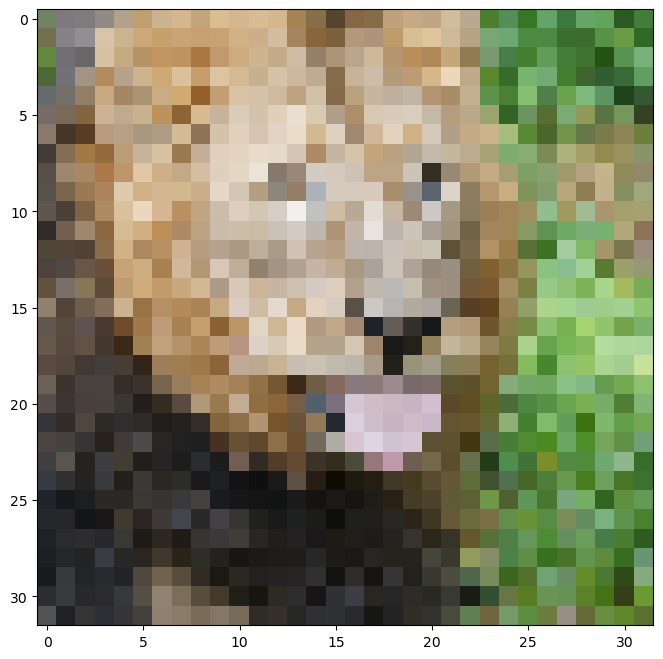

In [13]:
size = 32
train_data, test_data = get_image(size)

Some suggested hyperparameter choices to help you start
- hidden layer count: 4
- hidden layer size: 256
- number of epochs: 1000
- learning reate: 1e-4


#### Low Resolution Reconstruction - SGD - None Mapping

X_train.shape = (256, 2)


  0%|          | 0/1000 [00:00<?, ?it/s]

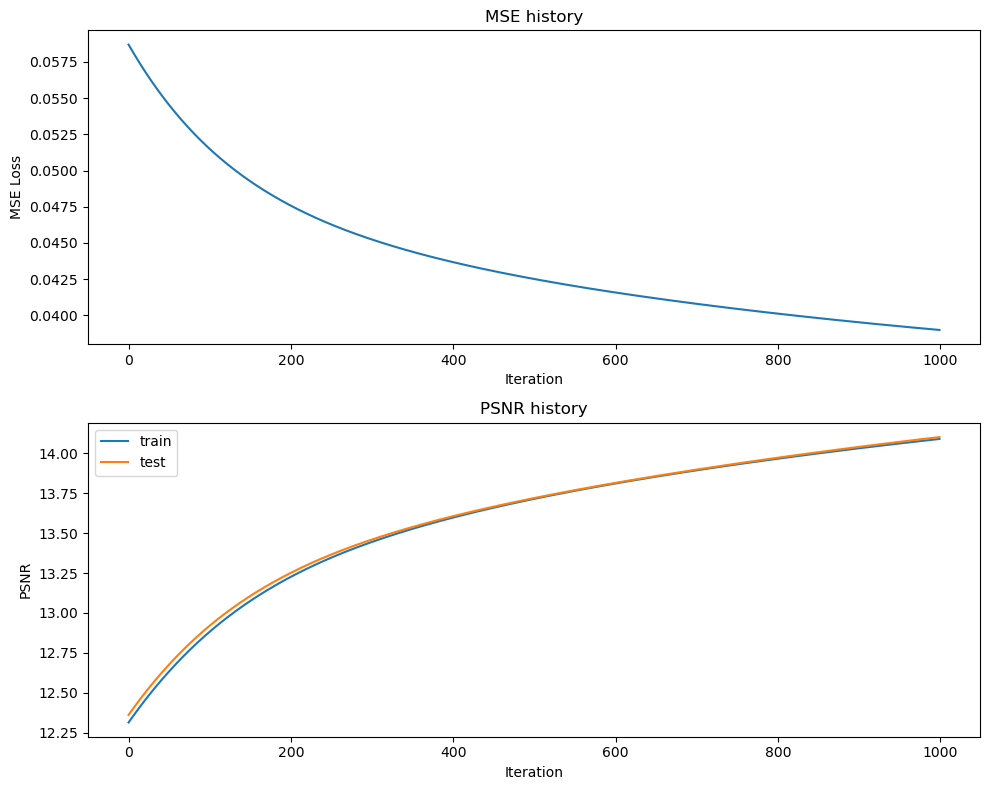

Final Test MSE 0.01944605666062722
Final Test psnr 14.101384574999301


C:\Users\kilob\AppData\Local\Temp\ipykernel_3352\3375680043.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N+1, N+1)


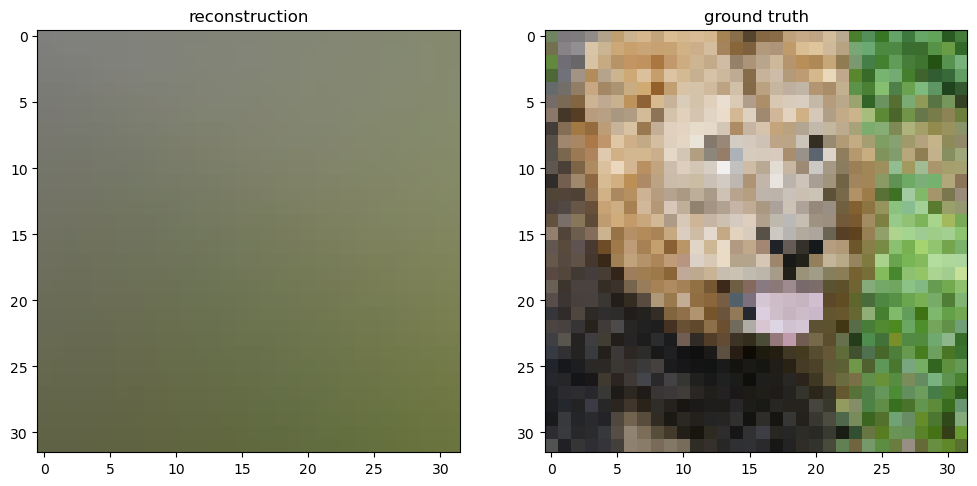

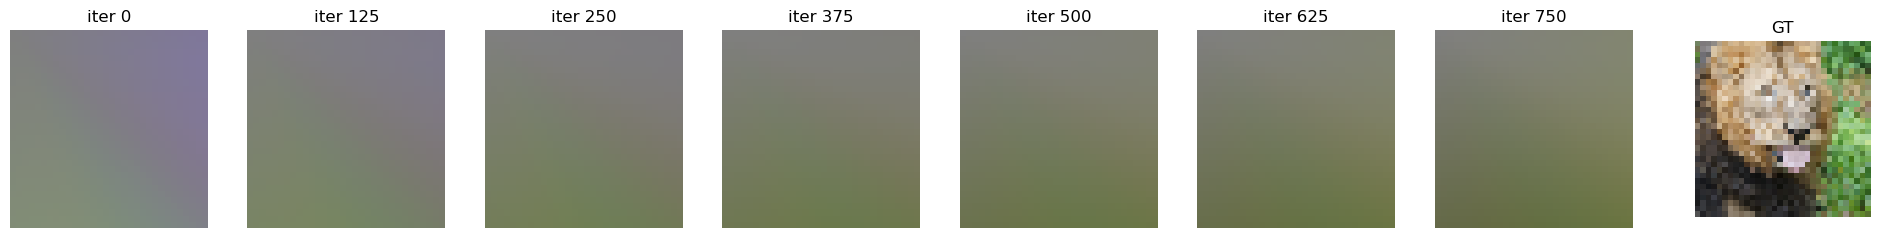

In [14]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict = get_B_dict()
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'none')

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
hidden_sizes = [1024] * 3
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size=2, num_layers=4, hidden_size=3, 
                                                                         hidden_sizes=hidden_sizes, output_size=3, epochs=1000, learning_rate=1e-4, opt="SGD")

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Adam - None Mapping

X_train.shape = (256, 2)


  0%|          | 0/1000 [00:00<?, ?it/s]

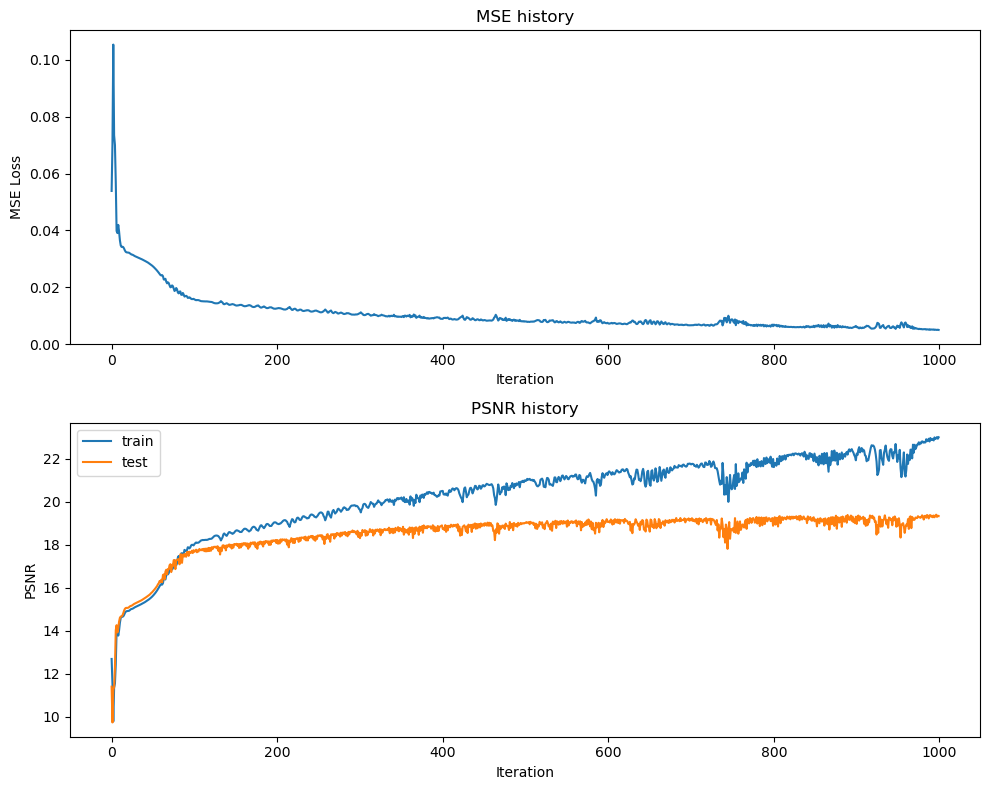

Final Test MSE 0.00582568347819869
Final Test psnr 19.336231195483165


C:\Users\kilob\AppData\Local\Temp\ipykernel_3352\3375680043.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N+1, N+1)


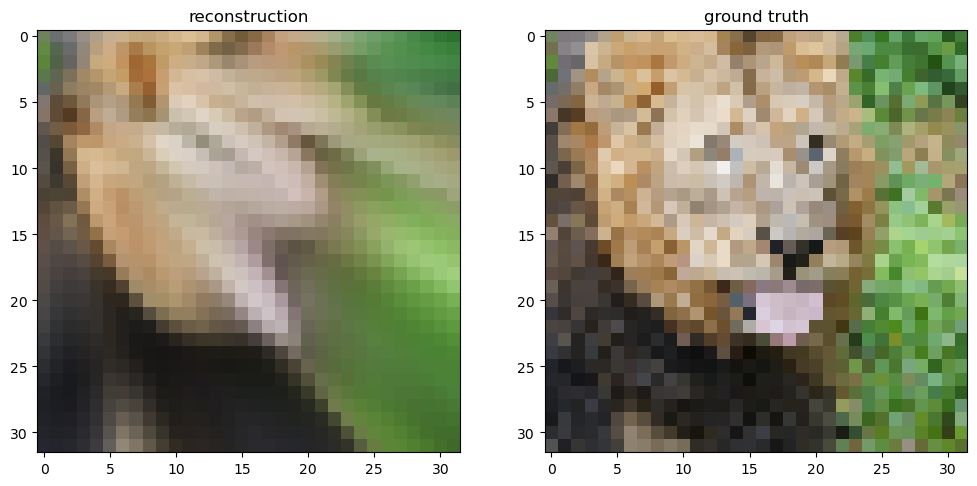

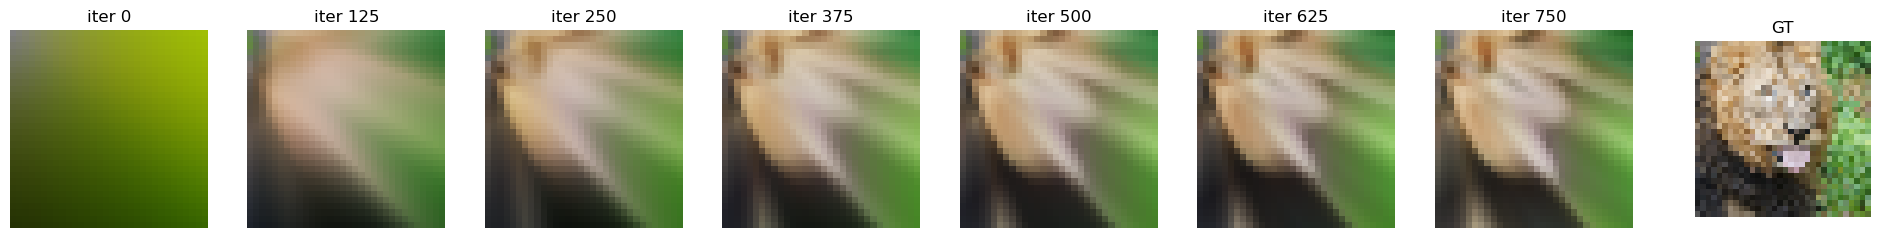

In [15]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict = get_B_dict()
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'none')

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
hidden_sizes = [1024] * 3
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size=2, num_layers=4, hidden_size=256, 
                                                                         hidden_sizes=hidden_sizes, output_size=3, epochs=1000, learning_rate=1e-4, opt="Adam")

# plot results of experiment
plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

#### Low Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

In [16]:
def train_wrapper(mapping, size, opt):
    # TODO implement
    # makes it easy to run all your mapping experiments in a for loop
    # this will similar to what you did previously in the last two sections
    # train_psnrs = []
    # test_psnrs = []
    # get input features
    # TODO implement this by using the get_B_dict() and get_input_features() helper functions
    B_dict = get_B_dict()
    X_train, y_train, X_test, y_test = get_input_features(B_dict, mapping)

    # run NN experiment on input features
    # TODO implement by using the NN_experiment() helper function
    hidden_sizes = [size] * 3
    net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size=X_train.shape[1], num_layers=4, hidden_size=256, 
                                                                          hidden_sizes=hidden_sizes, output_size=3, epochs=1000, learning_rate=1e-4, opt=opt)
    # train_psnrs.append(train_psnr)
    # test_psnrs.append(test_psnr)
    return {
        'net': net, 
        'train_psnrs': train_psnr, 
        'test_psnrs': test_psnr,
        'train_loss': train_loss,
        'pred_imgs': predicted_images
    }



In [17]:
outputs = {}
opt = 'SGD' # 'Adam' & 'SGD'
for k in tqdm(B_dict):
    print("training", k)
    outputs[k] = train_wrapper(k, 256, opt)

  0%|          | 0/5 [00:00<?, ?it/s]

training none
X_train.shape = (256, 2)


  0%|          | 0/1000 [00:00<?, ?it/s]

training basic
m: (256, 2)
x: (256, 2)
B: (2, 2)
x_proj: (256, 2)
return_v: (256, 4)
X_train.shape = (256, 4)
m: (1024, 2)
x: (1024, 2)
B: (2, 2)
x_proj: (1024, 2)
return_v: (1024, 4)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_1.0
m: (256, 2)
x: (256, 2)
B: (256, 2)
x_proj: (256, 256)
return_v: (256, 512)
X_train.shape = (256, 512)
m: (1024, 2)
x: (1024, 2)
B: (256, 2)
x_proj: (1024, 256)
return_v: (1024, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_10.0
m: (256, 2)
x: (256, 2)
B: (256, 2)
x_proj: (256, 256)
return_v: (256, 512)
X_train.shape = (256, 512)
m: (1024, 2)
x: (1024, 2)
B: (256, 2)
x_proj: (1024, 256)
return_v: (1024, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_100.0
m: (256, 2)
x: (256, 2)
B: (256, 2)
x_proj: (256, 256)
return_v: (256, 512)
X_train.shape = (256, 512)
m: (1024, 2)
x: (1024, 2)
B: (256, 2)
x_proj: (1024, 256)
return_v: (1024, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

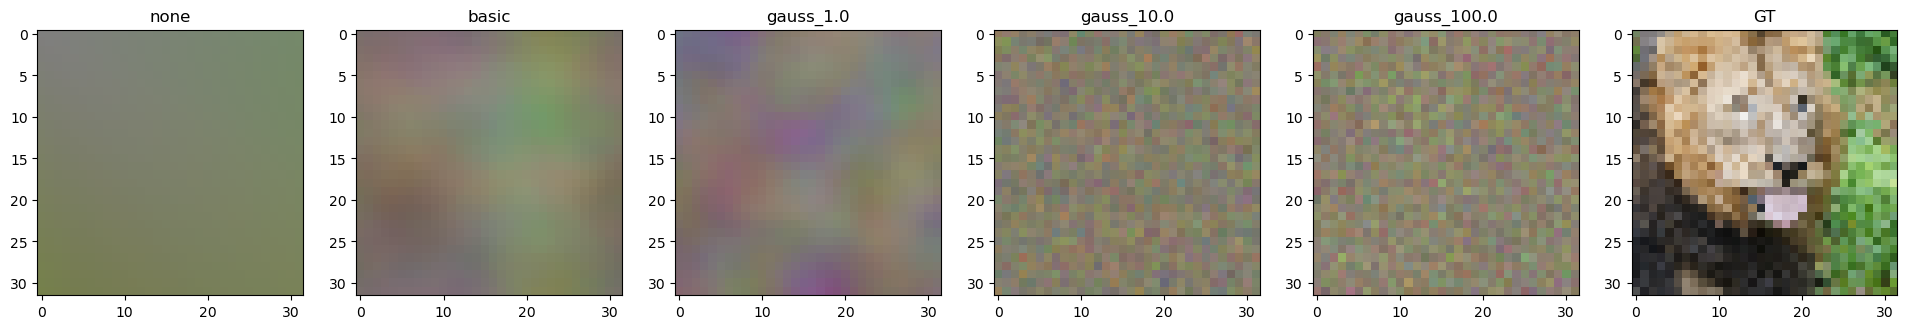

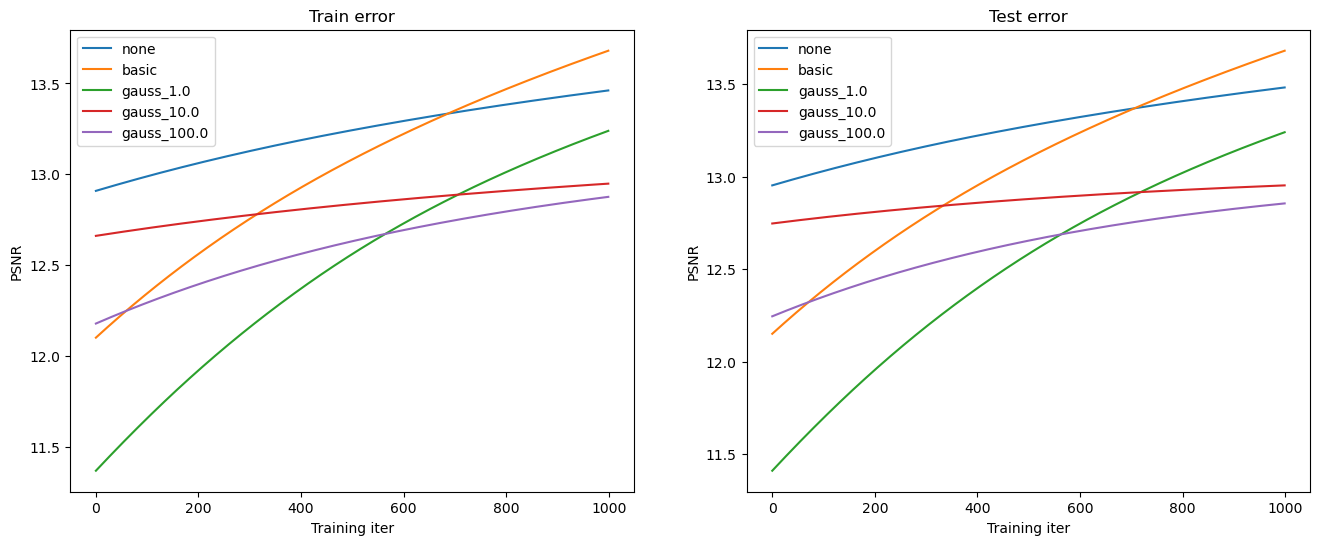

In [18]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs, y_test.reshape(size,size,3))

In [19]:
outputs_adam = {}
opt = 'Adam' # 'Adam' & 'SGD'
for k in tqdm(B_dict):
    print("training", k)
    outputs_adam[k] = train_wrapper(k, size, opt)

  0%|          | 0/5 [00:00<?, ?it/s]

training none
X_train.shape = (256, 2)


  0%|          | 0/1000 [00:00<?, ?it/s]

training basic
m: (256, 2)
x: (256, 2)
B: (2, 2)
x_proj: (256, 2)
return_v: (256, 4)
X_train.shape = (256, 4)
m: (1024, 2)
x: (1024, 2)
B: (2, 2)
x_proj: (1024, 2)
return_v: (1024, 4)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_1.0
m: (256, 2)
x: (256, 2)
B: (256, 2)
x_proj: (256, 256)
return_v: (256, 512)
X_train.shape = (256, 512)
m: (1024, 2)
x: (1024, 2)
B: (256, 2)
x_proj: (1024, 256)
return_v: (1024, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_10.0
m: (256, 2)
x: (256, 2)
B: (256, 2)
x_proj: (256, 256)
return_v: (256, 512)
X_train.shape = (256, 512)
m: (1024, 2)
x: (1024, 2)
B: (256, 2)
x_proj: (1024, 256)
return_v: (1024, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_100.0
m: (256, 2)
x: (256, 2)
B: (256, 2)
x_proj: (256, 256)
return_v: (256, 512)
X_train.shape = (256, 512)
m: (1024, 2)
x: (1024, 2)
B: (256, 2)
x_proj: (1024, 256)
return_v: (1024, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

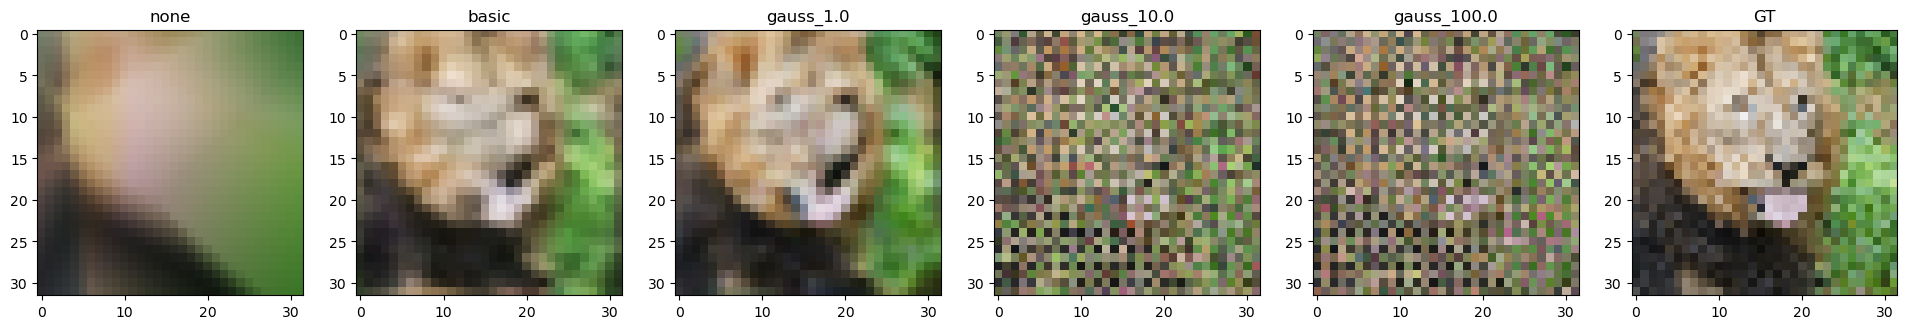

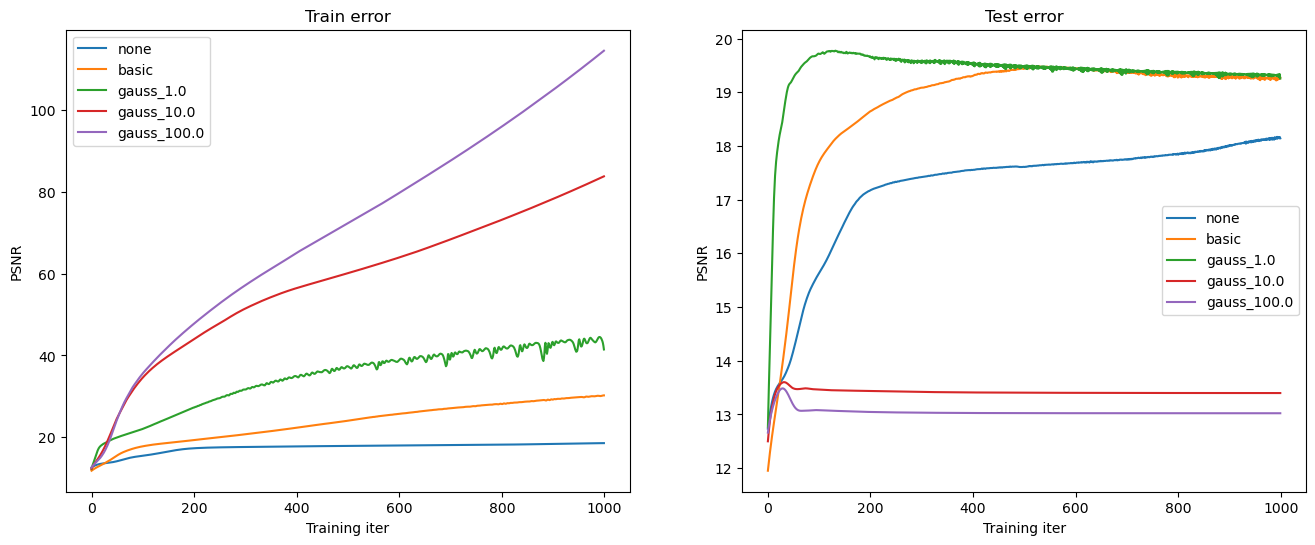

In [20]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs_adam, y_test.reshape(size,size,3))

# High Resolution Reconstruction

#### High Resolution Reconstruction - Optimizer of your Choice - Various Input Mapping Stategies

Repeat the previous experiment, but at the higher resolution. The reason why we have you first experiment with the lower resolution since it is faster to train and debug. Additionally, you will see how the mapping strategies perform better or worse at the two different input resolutions. 

C:\Users\kilob\AppData\Local\Temp\ipykernel_3352\2869637023.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


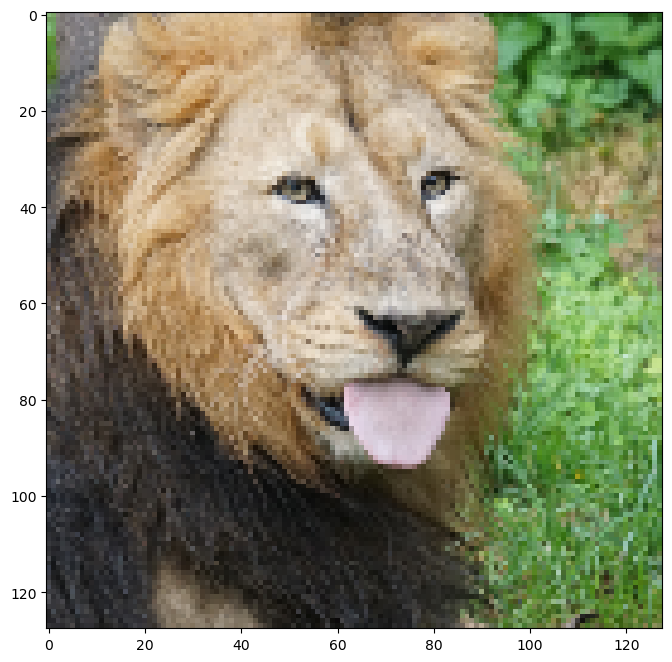

In [21]:
size = 128
train_data, test_data = get_image(size)

In [22]:
B_dict_high = get_B_dict()

outputs_high = {}
opt = 'SGD' # 'Adam' & 'SGD'
for k in tqdm(B_dict_high):
    print("training", k)
    outputs_high[k] = train_wrapper(k, size, opt)

  0%|          | 0/5 [00:00<?, ?it/s]

training none
X_train.shape = (4096, 2)


  0%|          | 0/1000 [00:00<?, ?it/s]

training basic
m: (4096, 2)
x: (4096, 2)
B: (2, 2)
x_proj: (4096, 2)
return_v: (4096, 4)
X_train.shape = (4096, 4)
m: (16384, 2)
x: (16384, 2)
B: (2, 2)
x_proj: (16384, 2)
return_v: (16384, 4)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_1.0
m: (4096, 2)
x: (4096, 2)
B: (256, 2)
x_proj: (4096, 256)
return_v: (4096, 512)
X_train.shape = (4096, 512)
m: (16384, 2)
x: (16384, 2)
B: (256, 2)
x_proj: (16384, 256)
return_v: (16384, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_10.0
m: (4096, 2)
x: (4096, 2)
B: (256, 2)
x_proj: (4096, 256)
return_v: (4096, 512)
X_train.shape = (4096, 512)
m: (16384, 2)
x: (16384, 2)
B: (256, 2)
x_proj: (16384, 256)
return_v: (16384, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_100.0
m: (4096, 2)
x: (4096, 2)
B: (256, 2)
x_proj: (4096, 256)
return_v: (4096, 512)
X_train.shape = (4096, 512)
m: (16384, 2)
x: (16384, 2)
B: (256, 2)
x_proj: (16384, 256)
return_v: (16384, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

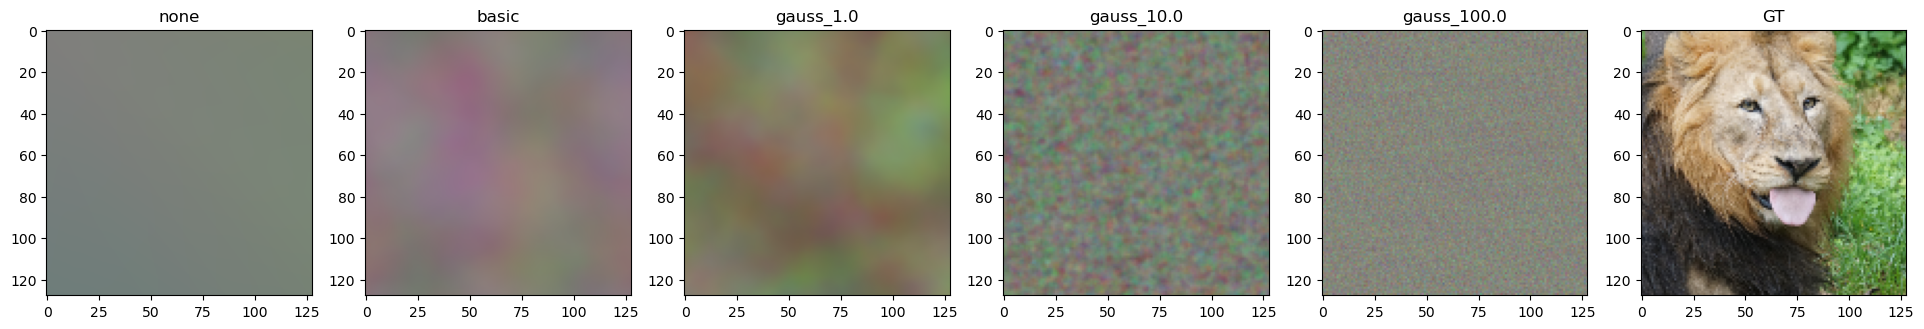

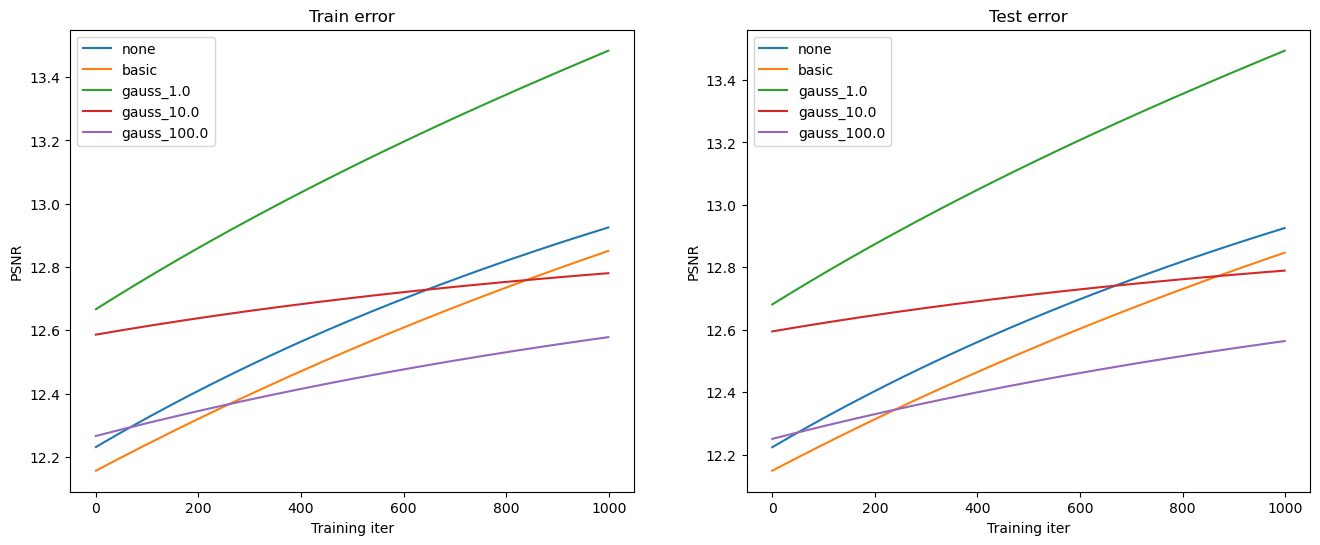

In [23]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs_high, test_data[1].reshape(-1, output_size).reshape(size,size,3))

In [24]:
outputs_high_adam = {}
opt = 'Adam' # 'Adam' & 'SGD'
for k in tqdm(B_dict_high):
    print("training", k)
    outputs_high_adam[k] = train_wrapper(k, size, opt)

  0%|          | 0/5 [00:00<?, ?it/s]

training none
X_train.shape = (4096, 2)


  0%|          | 0/1000 [00:00<?, ?it/s]

training basic
m: (4096, 2)
x: (4096, 2)
B: (2, 2)
x_proj: (4096, 2)
return_v: (4096, 4)
X_train.shape = (4096, 4)
m: (16384, 2)
x: (16384, 2)
B: (2, 2)
x_proj: (16384, 2)
return_v: (16384, 4)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_1.0
m: (4096, 2)
x: (4096, 2)
B: (256, 2)
x_proj: (4096, 256)
return_v: (4096, 512)
X_train.shape = (4096, 512)
m: (16384, 2)
x: (16384, 2)
B: (256, 2)
x_proj: (16384, 256)
return_v: (16384, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_10.0
m: (4096, 2)
x: (4096, 2)
B: (256, 2)
x_proj: (4096, 256)
return_v: (4096, 512)
X_train.shape = (4096, 512)
m: (16384, 2)
x: (16384, 2)
B: (256, 2)
x_proj: (16384, 256)
return_v: (16384, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

training gauss_100.0
m: (4096, 2)
x: (4096, 2)
B: (256, 2)
x_proj: (4096, 256)
return_v: (4096, 512)
X_train.shape = (4096, 512)
m: (16384, 2)
x: (16384, 2)
B: (256, 2)
x_proj: (16384, 256)
return_v: (16384, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

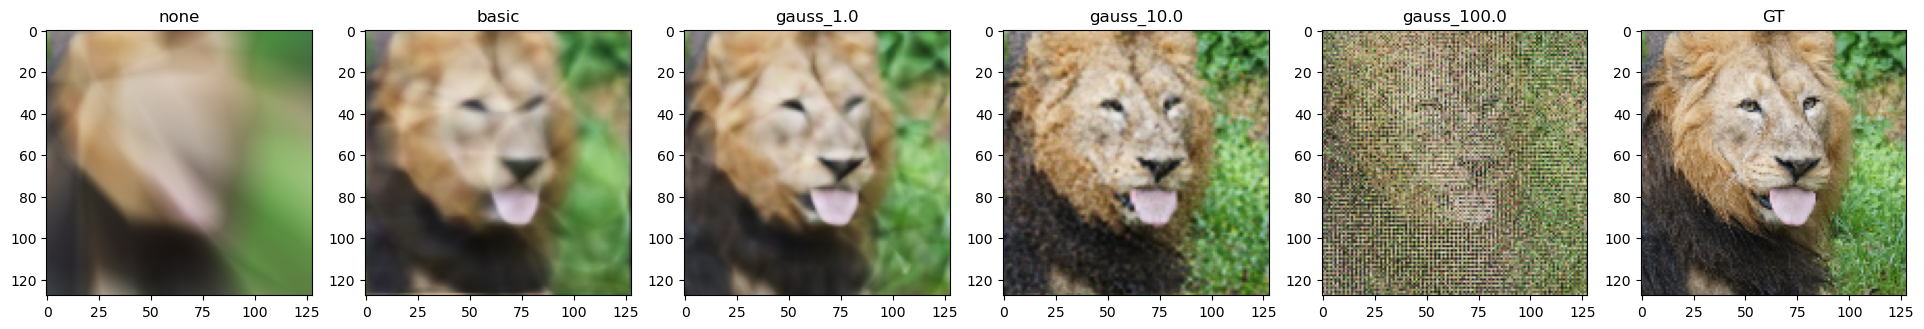

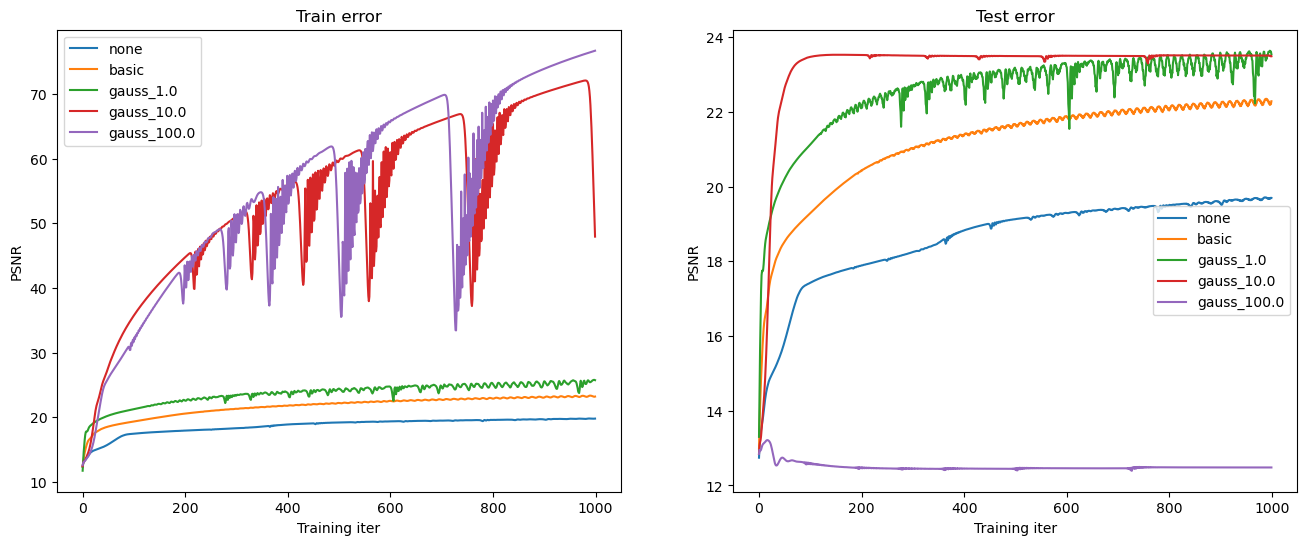

In [25]:
# if you did everything correctly so far, this should output a nice figure you can use in your report
plot_feature_mapping_comparison(outputs_high_adam, test_data[1].reshape(-1, output_size).reshape(size,size,3))

In [26]:
y_test.shape

(1024, 3)

In [27]:
test_data[1].shape

(128, 128, 3)

#### High Resolution Reconstruction - Image of your Choice

When choosing an image select one that you think will give you interesting results or a better insight into the performance of different feature mappings and explain why in your report template. 

C:\Users\kilob\AppData\Local\Temp\ipykernel_3352\2869637023.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_url)[..., :3] / 255.


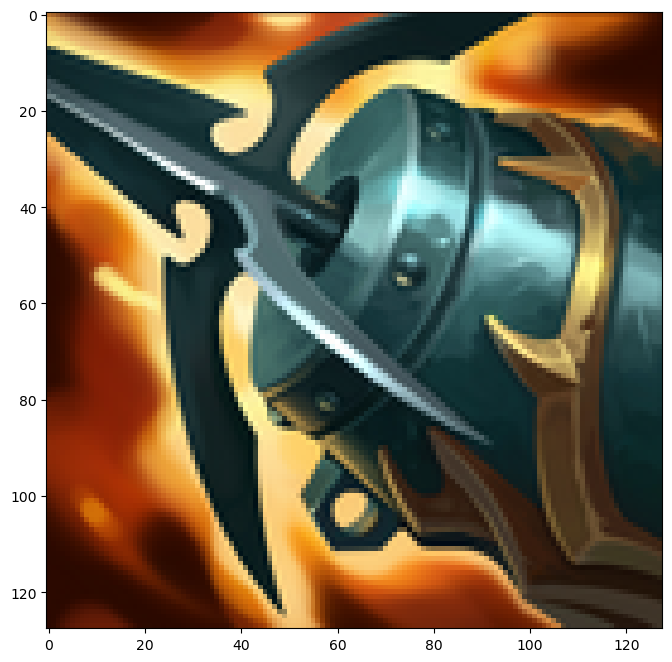

In [28]:
size = 128
# TODO pick an image and replace the url string
my_profile_url = "https://static.wikia.nocookie.net/leagueoflegends/images/e/e9/Kraken_Slayer_item_HD.png/revision/latest/scale-to-width-down/128?cb=20201110232124"
train_data, test_data = get_image(size, image_url=my_profile_url)

m: (4096, 2)
x: (4096, 2)
B: (256, 2)
x_proj: (4096, 256)
return_v: (4096, 512)
X_train.shape = (4096, 512)
m: (16384, 2)
x: (16384, 2)
B: (256, 2)
x_proj: (16384, 256)
return_v: (16384, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

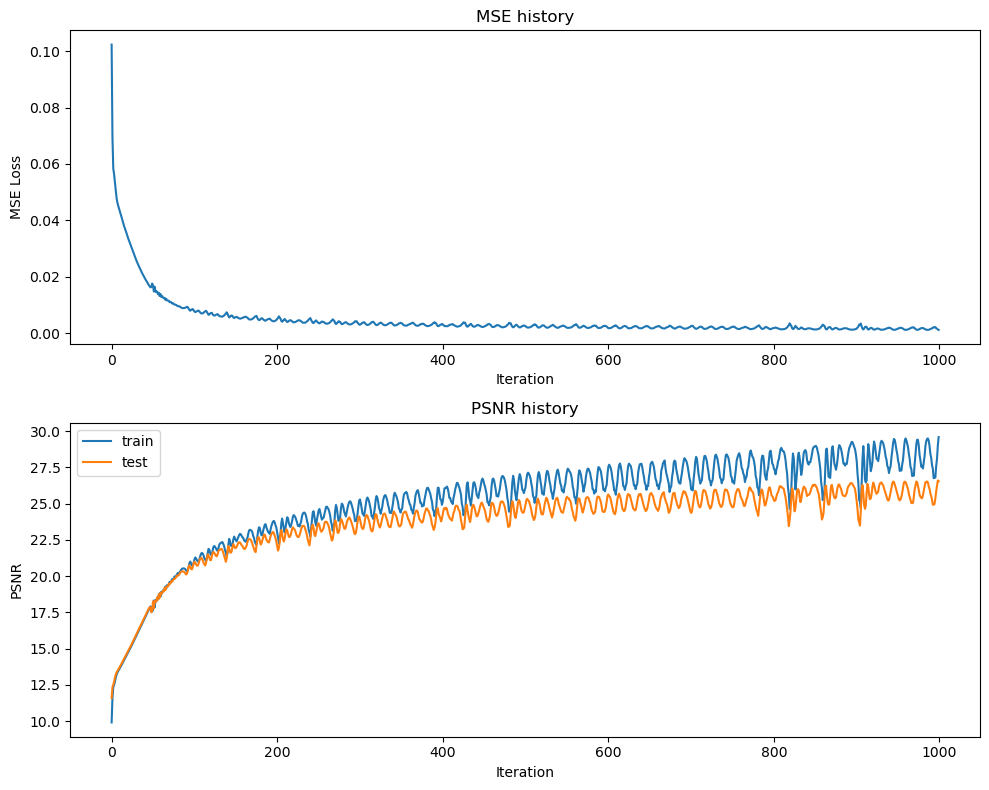

Final Test MSE 0.001106109111620978
Final Test psnr 26.551720344761893


C:\Users\kilob\AppData\Local\Temp\ipykernel_3352\3375680043.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, N+1, N+1)


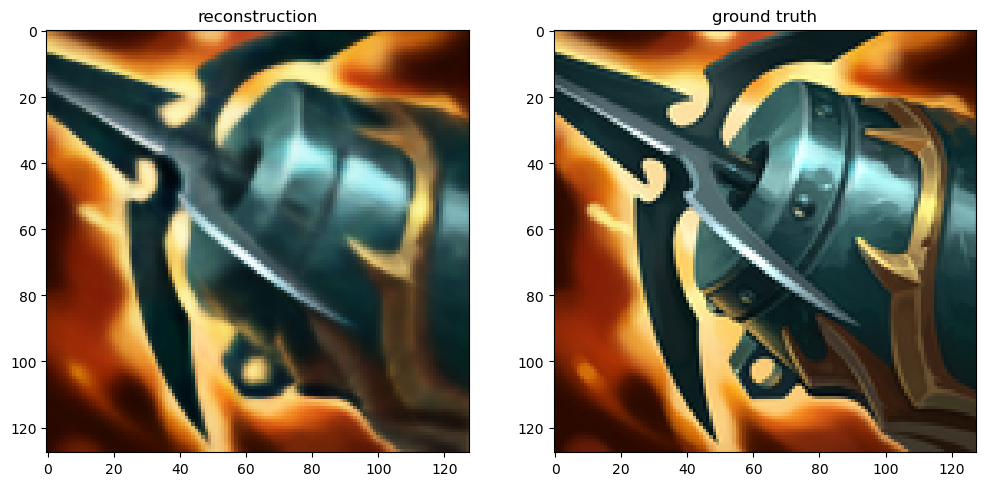

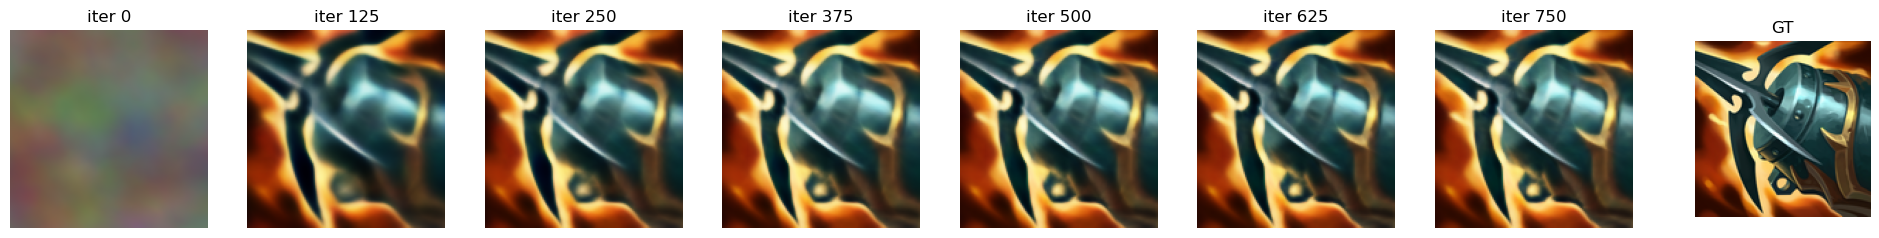

In [29]:
# get input features
# TODO implement this by using the get_B_dict() and get_input_features() helper functions
B_dict = get_B_dict()
X_train, y_train, X_test, y_test = get_input_features(B_dict, 'gauss_1.0')

# run NN experiment on input features
# TODO implement by using the NN_experiment() helper function
hidden_sizes = [256] * 3
net, train_psnr, test_psnr, train_loss, predicted_images = NN_experiment(X_train, y_train, X_test, y_test, input_size=512, num_layers=4, hidden_size=3, 
                                                                         hidden_sizes=hidden_sizes, output_size=3, epochs=1000, learning_rate=1e-4, opt="Adam")


plot_training_curves(train_loss, train_psnr, test_psnr)
plot_reconstruction(net.forward(X_test), y_test)
plot_reconstruction_progress(predicted_images, y_test)

# Reconstruction Process Video (Optional)
(For Fun!) Visualize the progress of training in a video 

In [30]:
# requires installing this additional dependency
!pip install imageio-ffmpeg

In [31]:
# multi video example
create_and_visualize_video(outputs_high_adam, epochs=1000, size=128)

,,,,
none,basic,gauss_1.0,gauss_10.0,gauss_100.0
